In [26]:
import os
os.environ["OMP_NUM_THREADS"]='1'
import osmnx as ox
import networkx as nx

import pandas as pd
import geopandas as gpd

from pyproj import Transformer 
import numpy as np
import scipy
from descartes import PolygonPatch

import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.patches import *
from matplotlib.lines import Line2D

import contextily as cx #Copyright (c) 2016, Dani Arribas-Bel. All rights reserved.

import math
import itertools
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
from IPython.display import Image, IFrame

from sklearn import cluster
from sklearn.cluster import KMeans


import pandapower as pp
from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly 


ALKIS Daten

In [27]:
#Polygon als GeoDataFrame
polygon = gpd.read_file(r".\Daten\Test")
#Polygon als Polygon-Objekt
new_poly = polygon["geometry"].iloc[0]

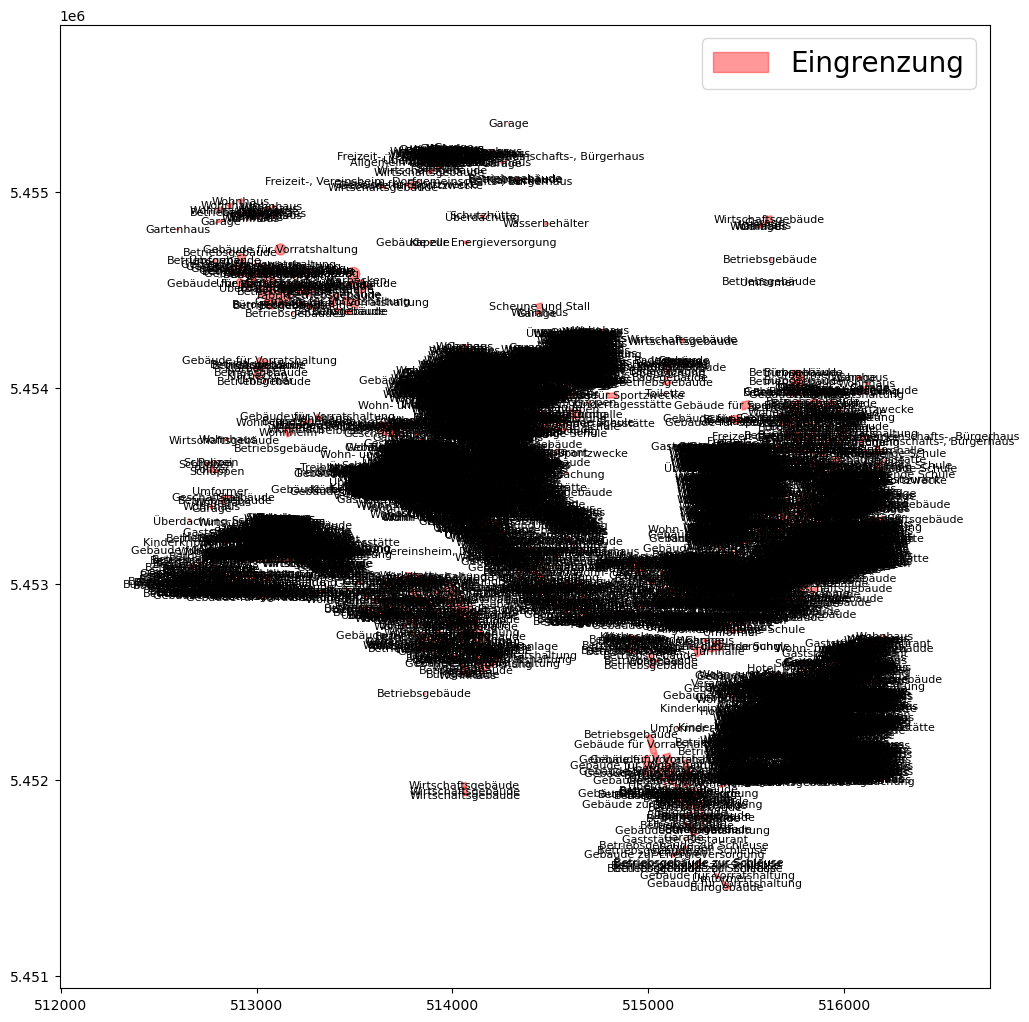

In [28]:
# PLOT DER EINGRENZUNG

#Konvertierung in metrisches System
alkis = polygon.to_crs(epsg=25832)
# geometrische Form des Polygons
polygon_geometry = alkis.unary_union
#Min & Max x,y werte des Polygons
min_x, min_y, max_x, max_y = polygon_geometry.bounds

zoom_factor = 500
#neue Eingrenzungen des Plots
new_min_x = min_x-zoom_factor
new_max_x = max_x+zoom_factor
new_min_y = min_y-zoom_factor
new_max_y = max_y+zoom_factor

fig, ax=plt.subplots(1, figsize=(12,15))
alkis.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.4)

#ax.set_axis_off()

ax.set_xlim(new_min_x, new_max_x)
ax.set_ylim(new_min_y, new_max_y)

legend_elements= [Patch(edgecolor='red', facecolor='red', alpha =0.4, label='Eingrenzung')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)
#print(alkis)
#for x, y, label in zip(alkis.geometry.centroid.x, alkis.geometry.centroid.y, alkis['funktion']):
#    ax.text(x, y, label, fontsize=8, ha='center', va='center')
#cx.add_basemap(ax=ax, crs=alkis.crs)


#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\eingrenzung_ind.svg', format='svg', bbox_inches='tight')

plt.show()

OSM Daten

In [32]:
#Polygon als GeoDataFrame

coordinates = [
    (545500, 512000),
    (545100, 512000),
    (545100, 516000),
    (545500, 516000),
    (545500, 512000)
]

geometry = Polygon(coordinates)

polygon = gpd.GeoDataFrame(index=[0],geometry=[geometry])
print(polygon)
#Polygon als Polygon-Objekt
new_poly = polygon["geometry"].iloc[0]

                                            geometry
0  POLYGON ((545500.000 512000.000, 545100.000 51...


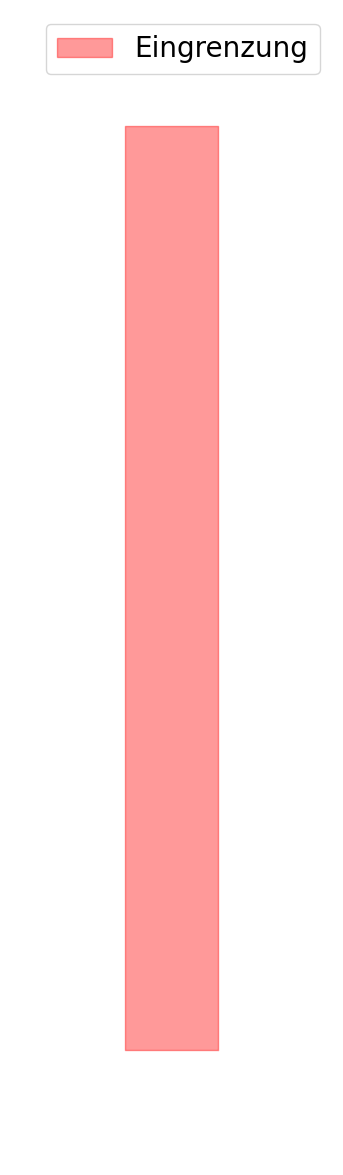

In [36]:
# PLOT DER EINGRENZUNG

#Konvertierung in metrisches System
polygon.crs = "EPSG:25832"
poly_draw = polygon
# geometrische Form des Polygons
polygon_geometry = poly_draw.unary_union
#Min & Max x,y werte des Polygons
min_x, min_y, max_x, max_y = polygon_geometry.bounds

zoom_factor = 500
#neue Eingrenzungen des Plots
new_min_x = min_x-zoom_factor
new_max_x = max_x+zoom_factor
new_min_y = min_y-zoom_factor
new_max_y = max_y+zoom_factor

fig, ax=plt.subplots(1, figsize=(12,15))
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.4)

ax.set_axis_off()

ax.set_xlim(new_min_x, new_max_x)
ax.set_ylim(new_min_y, new_max_y)

legend_elements= [Patch(edgecolor='red', facecolor='red', alpha =0.4, label='Eingrenzung')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

#cx.add_basemap(ax=ax, crs=poly_draw.crs)


#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\eingrenzung_ind.svg', format='svg', bbox_inches='tight')

plt.show()

In [37]:
#alle Gebäude innerhalb des Polygons erfassen
buildings = ox.features.features_from_polygon(new_poly, tags={"building":True})

#Auf wichtigste Columns beschränken:
buildings = buildings.filter(['geometry', 'nodes', 'building','building:levels','power', 'ways', axis=='columns'])

#Alle NaN Stockwerkwerte mit 1 ersetzen:
buildings[['building:levels']] = buildings[['building:levels']].fillna(int(1))

RuntimeError: Unable to determine UTM CRS

In [14]:
#Gebäudezentren bestimmen
#buildings = buildings.to_crs(epsg=4326)
centroid_calc = buildings.to_crs(epsg=25832)#4326
centroids = centroid_calc.centroid
lons = list(centroids.x)
lats = list(centroids.y)

building_coords = [[lons[i],lats[i]] for i in range(len(lons))]
buildings = buildings.to_crs(epsg=25832)
#print(building_coords)

Zuordnen

In [21]:
def assign_function_to_building(buildings_gdf,alkis_gdf):
    #ordnet Gebäuden das Passende Alkis Gebäude bzw. dessen Funktion zu 

    buildings_gdf['function'] = None    #Standartwert der Funktion

    for b_index, osm_building in buildings_gdf.iterrows():

        overlapping = alkis_gdf[alkis_gdf.geometry.intersects(osm_building.geometry)]
        print(overlapping)


        #found_building = False
        # Überprüfe, in welchem Gebäude der Punkt liegt
        #for a_index, a_building in alkis_gdf.iterrows():
        #    print(a_building.geometry)
        #    print(osm_building.geometry)
        #    if a_building.geometry.within(osm_building.geometry):
        #        # Füge die Erzeugungsleistung der Anlage dem Gebäude hinzu
        #        buildings_gdf.at[b_index, 'function'] = alkis_gdf.at[a_index,'function']
        #        print("found")
        #        found_building = True
        #        break  # Beende die Schleife, wenn das Gebäude gefunden wurde
        
        # Wenn punkt nicht direkt in einem gebäude liegt wird er dem nächsten Gebäude zugeordnet
        #if not found_building:
        #    nearest_poly, min_distance = nearest_polygon(point.geometry, buildings_gdf.geometry)
        #    for index, building in buildings_gdf.iterrows():
        #       if building.geometry.equals(nearest_poly):
        #            # Füge die Erzeugungsleistung der Anlage dem Gebäude hinzu
        #            buildings_gdf.at[index, 'Erzeugungsleistung'] += point['Nettonennleistung der Einheit']
        #            # Füge den Netzanschluss der Anlage dem Gebäude hinzu
        #            buildings_gdf.at[index, 'Netzanschluss'] += point['Spannungsebene'] + ','
        #            break

    return buildings_gdf

In [22]:
buildings = assign_function_to_building(buildings,alkis)
print(buildings.iloc[0])

Empty GeoDataFrame
Columns: [oid, aktualit, gebnutzbez, funktion, fktkurz, name, anzahlgs, lagebeztxt, geometry]
Index: []
Empty GeoDataFrame
Columns: [oid, aktualit, gebnutzbez, funktion, fktkurz, name, anzahlgs, lagebeztxt, geometry]
Index: []
Empty GeoDataFrame
Columns: [oid, aktualit, gebnutzbez, funktion, fktkurz, name, anzahlgs, lagebeztxt, geometry]
Index: []
Empty GeoDataFrame
Columns: [oid, aktualit, gebnutzbez, funktion, fktkurz, name, anzahlgs, lagebeztxt, geometry]
Index: []
Empty GeoDataFrame
Columns: [oid, aktualit, gebnutzbez, funktion, fktkurz, name, anzahlgs, lagebeztxt, geometry]
Index: []
Empty GeoDataFrame
Columns: [oid, aktualit, gebnutzbez, funktion, fktkurz, name, anzahlgs, lagebeztxt, geometry]
Index: []
Empty GeoDataFrame
Columns: [oid, aktualit, gebnutzbez, funktion, fktkurz, name, anzahlgs, lagebeztxt, geometry]
Index: []
Empty GeoDataFrame
Columns: [oid, aktualit, gebnutzbez, funktion, fktkurz, name, anzahlgs, lagebeztxt, geometry]
Index: []
Empty GeoDataFra